In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 16
learning_rate  = 1e-2
momentum = 0.5
epochs = 30
patience = 5

In [3]:
train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transforms.Compose([
                                transforms.Resize([256, 256]),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),                       # 数据类型转化
                                transforms.Normalize(
                                    (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # 数据归一化处理
                            ]))

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                           ]))

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out = self.feature(x)
        return out

In [8]:
class InceptionA(nn.Module):
    def __init__(self, in_channels, out_channels1, temp_channels2, out_channels2, temp_channels3, out_channels3, out_channels4):
        super(InceptionA, self).__init__()
        self.branch1 = BasicConv2d(
            in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride=1, padding=0, bias=False)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=out_channels2,
                        kernel_size=5, stride=1, padding=2, bias=False),
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels3,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=out_channels3,
                        kernel_size=3, stride=1, padding=1, bias=False),
            BasicConv2d(in_channels=out_channels3, out_channels=out_channels3,
                        kernel_size=3, stride=1, padding=1, bias=False),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=in_channels, out_channels=out_channels4,
                        kernel_size=1, padding=0, bias=False),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

In [9]:
class InceptionB(nn.Module):
    def __init__(self, in_channels, out_channels1, temp_channels2, out_channels2):
        super(InceptionB, self).__init__()
        self.branch1 = BasicConv2d(
            in_channels=in_channels, out_channels=out_channels1, kernel_size=3, stride=2, padding=0, bias=False)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=out_channels2,
                        kernel_size=3, stride=1, padding=1, bias=False),
            BasicConv2d(in_channels=out_channels2, out_channels=out_channels2,
                        kernel_size=3, stride=2, padding=0, bias=False),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out = torch.cat([out1, out2, out3], dim=1)
        return out

In [10]:
class InceptionC(nn.Module):
    def __init__(self, in_channels, out_channels1, temp_channels2, out_channels2, temp_channels3, out_channels3, out_channels4):
        super(InceptionC, self).__init__()
        self.branch1 = BasicConv2d(
            in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride=1, padding=0, bias=False)
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=temp_channels2,
                        kernel_size=(1, 7), stride=1, padding=(0, 3), bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=out_channels2,
                        kernel_size=(7, 1), stride=1, padding=(3, 0), bias=False),
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels3,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(7,1), stride=1, padding=(3,0), bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(1,7), stride=1, padding=(0,3), bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(7,1), stride=1, padding=(3,0), bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=out_channels3,
                        kernel_size=(1,7), stride=1, padding=(0,3), bias=False),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=in_channels, out_channels=out_channels4,
                        kernel_size=1, padding=0, bias=False),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

In [11]:
class InceptionD(nn.Module):
    def __init__(self, in_channels, temp_channels1, out_channels1, out_channels2):
        super(InceptionD, self).__init__()
        self.branch1 = nn.Sequential(
            BasicConv2d(
                in_channels=in_channels, out_channels=temp_channels1, kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(
                in_channels=temp_channels1, out_channels=out_channels1, kernel_size=3, stride=2, padding=0, bias=False)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=out_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=out_channels2, out_channels=out_channels2,
                        kernel_size=(1,7), stride=1, padding=(0,3), bias=False),
            BasicConv2d(in_channels=out_channels2, out_channels=out_channels2,
                        kernel_size=(7,1), stride=1, padding=(3,0), bias=False),
            BasicConv2d(in_channels=out_channels2, out_channels=out_channels2,
                        kernel_size=3, stride=2, padding=0, bias=False),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out = torch.cat([out1, out2, out3], dim=1)
        return out

In [12]:
class InceptionE(nn.Module):
    def __init__(self, in_channels, out_channels1, temp_channels2, out_channels2, temp_channels3, out_channels3, out_channels4):
        super(InceptionE, self).__init__()
        self.branch1 = BasicConv2d(
            in_channels=in_channels, out_channels=out_channels1, kernel_size=1, stride=1, padding=0, bias=False)
        self.branch2_1 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=temp_channels2,
                        kernel_size=(1, 3), stride=1, padding=(0, 1), bias=False),
        )
        self.branch2_2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels2,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels2, out_channels=out_channels2,
                        kernel_size=(3, 1), stride=1, padding=(1, 0), bias=False),
        )
        self.branch3_1 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels3,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(3,3), stride=1, padding=1, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=out_channels3,
                        kernel_size=(1,3), stride=1, padding=(0,1), bias=False),
        )
        self.branch3_2 = nn.Sequential(
            BasicConv2d(in_channels=in_channels, out_channels=temp_channels3,
                        kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=temp_channels3,
                        kernel_size=(3,3), stride=1, padding=1, bias=False),
            BasicConv2d(in_channels=temp_channels3, out_channels=out_channels3,
                        kernel_size=(3,1), stride=1, padding=(1,0), bias=False),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels=in_channels, out_channels=out_channels4,
                        kernel_size=1, padding=0, bias=False),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2_1 = self.branch2_1(x)
        out2_2 = self.branch2_2(x)
        out3_1 = self.branch3_1(x)
        out3_2 = self.branch3_2(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2_1, out2_2, out3_1, out3_2, out4], dim=1)
        return out

In [13]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionAux, self).__init__()
        self.auxiliary_avgpool = nn.AvgPool2d(
            kernel_size=3, stride=1, padding=1)
        self.auxiliary_conv1 = BasicConv2d(
            in_channels=in_channels, out_channels=128, kernel_size=1, padding=0, bias=False)
        self.auxiliary_conv2 = BasicConv2d(
            in_channels=128, out_channels=in_channels, kernel_size=5, padding=0, bias=False)
        self.auxiliary_dropout = nn.Dropout(p=0.5)
        self.auxiliary_linear1 = nn.Linear(
            in_features=in_channels, out_features=out_channels)

    def forward(self, x):
        x = self.auxiliary_conv1(self.auxiliary_avgpool(x))
        x = self.auxiliary_conv2(x)
        x = x.view(x.size(0), -1)
        out = self.auxiliary_linear1(self.auxiliary_dropout(x))
        return out

In [14]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=10, stage='non_train'):
        super(InceptionV3, self).__init__()
        self.stage = stage
        # input [batch,3,224,224] -> [batch,192,56,56]
        self.block1 = nn.Sequential(
            BasicConv2d(in_channels=3, out_channels=32,
                       kernel_size=3, stride=2, padding=0, bias=False),
            BasicConv2d(in_channels=32, out_channels=32,
                       kernel_size=3, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=32, out_channels=64,
                       kernel_size=3, stride=1, padding=1, bias=False),
            nn.MaxPool2d(kernel_size=3, stride=2),
            BasicConv2d(in_channels=64, out_channels=80,
                       kernel_size=1, stride=1, padding=0, bias=False),
            BasicConv2d(in_channels=80, out_channels=192,
                       kernel_size=3, stride=1, padding=0, bias=False),
        )
        # input [batch,64,56,56] -> [batch,192,28,28]
        self.block2 = nn.Sequential(
            InceptionA(in_channels=192, out_channels1=64, temp_channels2=48,
                       out_channels2=64, temp_channels3=64, out_channels3=96, out_channels4=32),
            InceptionA(in_channels=256, out_channels1=64, temp_channels2=48,
                       out_channels2=64, temp_channels3=64, out_channels3=96, out_channels4=64),
            InceptionA(in_channels=288, out_channels1=64, temp_channels2=48,
                       out_channels2=64, temp_channels3=64, out_channels3=96, out_channels4=64),
        )
        # input[batch, 192, 28, 28] -> [batch, 480, 14, 14]
        self.block3 = InceptionB(
            in_channels=288, out_channels1=384, temp_channels2=64, out_channels2=96)
        # input [batch,480,14,14] -> [batch,832,7,7]
        self.block4 = nn.Sequential(
            InceptionC(in_channels=768, out_channels1=192, temp_channels2=128,
                       out_channels2=192, temp_channels3=128, out_channels3=192, out_channels4=192),
            InceptionC(in_channels=768, out_channels1=192, temp_channels2=160,
                       out_channels2=192, temp_channels3=160, out_channels3=192, out_channels4=192),
            InceptionC(in_channels=768, out_channels1=192, temp_channels2=160,
                       out_channels2=192, temp_channels3=160, out_channels3=192, out_channels4=192),
            InceptionC(in_channels=768, out_channels1=192, temp_channels2=192,
                       out_channels2=192, temp_channels3=192, out_channels3=192, out_channels4=192),
        )
        if self.stage == 'train':
            self.AuxLogits = InceptionAux(
                in_channels=768, out_channels=num_classes)
        else:
            self.AuxLogits = nn.Sequential()
        # input [batch,832,7,7] -> [batch,1024,7,7]
        self.block5 = InceptionD(
            in_channels=768, temp_channels1=192, out_channels1=320, out_channels2=192)
        self.block6 = nn.Sequential(
            InceptionE(in_channels=1280, out_channels1=320, temp_channels2=384,
                       out_channels2=384, temp_channels3=448, out_channels3=384, out_channels4=192),
            InceptionE(in_channels=2048, out_channels1=320, temp_channels2=384,
                       out_channels2=384, temp_channels3=448, out_channels3=384, out_channels4=192),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(
            in_features=2048, out_features=num_classes, bias=True)

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        aux = self.AuxLogits(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        if self.stage == 'train':
            aux = self.aux_logits(aux)
            return aux, out
        else:
            return out

In [15]:
net = InceptionV3().to(DEVICE)
# net = models.inception_v3().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.7, patience=1)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [18]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()
        
        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss /= len(val_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [19]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()
            

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))
    
    return val_loss, val_acc

In [20]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [21]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [22]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))
    
    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)
    
    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')
    
    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [23]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)
        
        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)
    
    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.315296
Train Epoch: 1 [1600/40000 (4%)]	Loss: 2.003039
Train Epoch: 1 [3200/40000 (8%)]	Loss: 2.104203
Train Epoch: 1 [4800/40000 (12%)]	Loss: 2.209575
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.140210
Train Epoch: 1 [8000/40000 (20%)]	Loss: 1.780073
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.850136
Train Epoch: 1 [11200/40000 (28%)]	Loss: 1.828363
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.674988
Train Epoch: 1 [14400/40000 (36%)]	Loss: 1.531071
Train Epoch: 1 [16000/40000 (40%)]	Loss: 1.901143
Train Epoch: 1 [17600/40000 (44%)]	Loss: 1.612893
Train Epoch: 1 [19200/40000 (48%)]	Loss: 2.130442
Train Epoch: 1 [20800/40000 (52%)]	Loss: 1.473435
Train Epoch: 1 [22400/40000 (56%)]	Loss: 2.721911
Train Epoch: 1 [24000/40000 (60%)]	Loss: 1.434823
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.713595
Train Epoch: 1 [27200/40000 (68%)]	Loss: 1.847266
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.511881
Train Epoch: 1 [30400/40000 (76%)]	Loss: 1.719664
Train Epoch: 

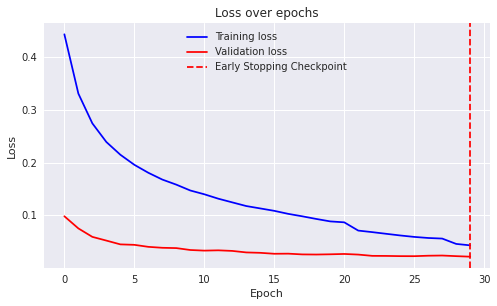

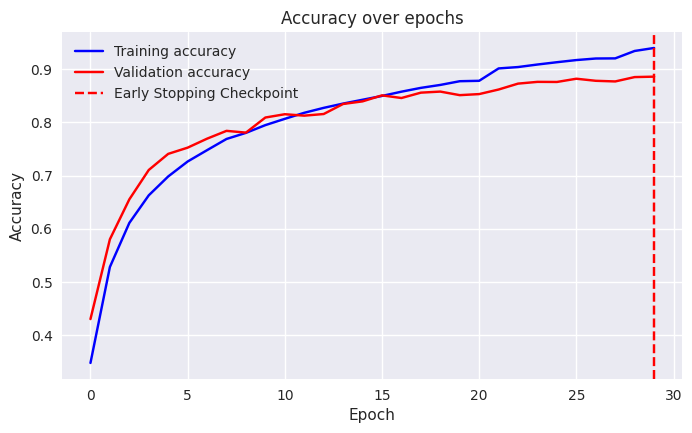

In [24]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'InceptionV3 - predictions')

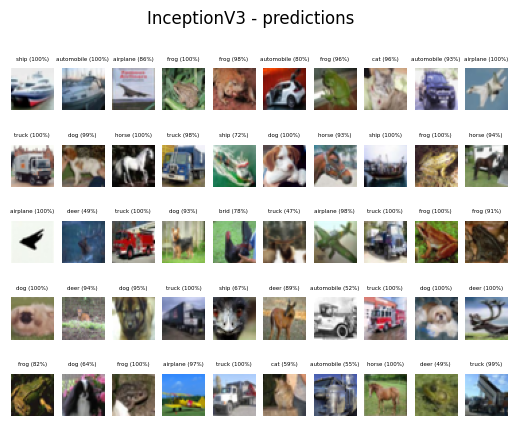

In [25]:
CIFAR_dict = {0: 'airplane',
              1: 'automobile',
              2: 'brid',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[int(torch.argmax(probs))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('InceptionV3 - predictions')

In [ ]:
"""
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 192, 52, 52]         --
|    └─BasicConv2d: 2-1                  [-1, 32, 111, 111]        --
|    |    └─Sequential: 3-1              [-1, 32, 111, 111]        928
|    └─BasicConv2d: 2-2                  [-1, 32, 109, 109]        --
|    |    └─Sequential: 3-2              [-1, 32, 109, 109]        9,280
|    └─BasicConv2d: 2-3                  [-1, 64, 109, 109]        --
|    |    └─Sequential: 3-3              [-1, 64, 109, 109]        18,560
|    └─MaxPool2d: 2-4                    [-1, 64, 54, 54]          --
|    └─BasicConv2d: 2-5                  [-1, 80, 54, 54]          --
|    |    └─Sequential: 3-4              [-1, 80, 54, 54]          5,280
|    └─BasicConv2d: 2-6                  [-1, 192, 52, 52]         --
|    |    └─Sequential: 3-5              [-1, 192, 52, 52]         138,624
├─Sequential: 1-2                        [-1, 288, 52, 52]         --
|    └─InceptionA: 2-7                   [-1, 256, 52, 52]         --
|    |    └─BasicConv2d: 3-6             [-1, 64, 52, 52]          12,416
|    |    └─Sequential: 3-7              [-1, 64, 52, 52]          86,240
|    |    └─Sequential: 3-8              [-1, 96, 52, 52]          151,040
|    |    └─Sequential: 3-9              [-1, 32, 52, 52]          6,208
|    └─InceptionA: 2-8                   [-1, 288, 52, 52]         --
|    |    └─BasicConv2d: 3-10            [-1, 64, 52, 52]          16,512
|    |    └─Sequential: 3-11             [-1, 64, 52, 52]          89,312
|    |    └─Sequential: 3-12             [-1, 96, 52, 52]          155,136
|    |    └─Sequential: 3-13             [-1, 64, 52, 52]          16,512
|    └─InceptionA: 2-9                   [-1, 288, 52, 52]         --
|    |    └─BasicConv2d: 3-14            [-1, 64, 52, 52]          18,560
|    |    └─Sequential: 3-15             [-1, 64, 52, 52]          90,848
|    |    └─Sequential: 3-16             [-1, 96, 52, 52]          157,184
|    |    └─Sequential: 3-17             [-1, 64, 52, 52]          18,560
├─InceptionB: 1-3                        [-1, 768, 25, 25]         --
|    └─BasicConv2d: 2-10                 [-1, 384, 25, 25]         --
|    |    └─Sequential: 3-18             [-1, 384, 25, 25]         996,096
|    └─Sequential: 2-11                  [-1, 96, 25, 25]          --
|    |    └─BasicConv2d: 3-19            [-1, 64, 52, 52]          18,560
|    |    └─BasicConv2d: 3-20            [-1, 96, 52, 52]          55,488
|    |    └─BasicConv2d: 3-21            [-1, 96, 25, 25]          83,136
|    └─Sequential: 2-12                  [-1, 288, 25, 25]         --
|    |    └─MaxPool2d: 3-22              [-1, 288, 25, 25]         --
|    |    └─BatchNorm2d: 3-23            [-1, 288, 25, 25]         576
|    |    └─ReLU: 3-24                   [-1, 288, 25, 25]         --
├─Sequential: 1-4                        [-1, 768, 25, 25]         --
|    └─InceptionC: 2-13                  [-1, 768, 25, 25]         --
|    |    └─BasicConv2d: 3-25            [-1, 192, 25, 25]         147,840
|    |    └─Sequential: 3-26             [-1, 192, 25, 25]         385,920
|    |    └─Sequential: 3-27             [-1, 192, 25, 25]         615,808
|    |    └─Sequential: 3-28             [-1, 192, 25, 25]         147,840
|    └─InceptionC: 2-14                  [-1, 768, 25, 25]         --
|    |    └─BasicConv2d: 3-29            [-1, 192, 25, 25]         147,840
|    |    └─Sequential: 3-30             [-1, 192, 25, 25]         518,144
|    |    └─Sequential: 3-31             [-1, 192, 25, 25]         877,184
|    |    └─Sequential: 3-32             [-1, 192, 25, 25]         147,840
|    └─InceptionC: 2-15                  [-1, 768, 25, 25]         --
|    |    └─BasicConv2d: 3-33            [-1, 192, 25, 25]         147,840
|    |    └─Sequential: 3-34             [-1, 192, 25, 25]         518,144
|    |    └─Sequential: 3-35             [-1, 192, 25, 25]         877,184
|    |    └─Sequential: 3-36             [-1, 192, 25, 25]         147,840
|    └─InceptionC: 2-16                  [-1, 768, 25, 25]         --
|    |    └─BasicConv2d: 3-37            [-1, 192, 25, 25]         147,840
|    |    └─Sequential: 3-38             [-1, 192, 25, 25]         664,704
|    |    └─Sequential: 3-39             [-1, 192, 25, 25]         1,181,568
|    |    └─Sequential: 3-40             [-1, 192, 25, 25]         147,840
├─Sequential: 1-5                        [-1, 768, 25, 25]         --
├─InceptionD: 1-6                        [-1, 1280, 12, 12]        --
|    └─Sequential: 2-17                  [-1, 320, 12, 12]         --
|    |    └─BasicConv2d: 3-41            [-1, 192, 25, 25]         147,840
|    |    └─BasicConv2d: 3-42            [-1, 320, 12, 12]         553,600
|    └─Sequential: 2-18                  [-1, 192, 12, 12]         --
|    |    └─BasicConv2d: 3-43            [-1, 192, 25, 25]         147,840
|    |    └─BasicConv2d: 3-44            [-1, 192, 25, 25]         258,432
|    |    └─BasicConv2d: 3-45            [-1, 192, 25, 25]         258,432
|    |    └─BasicConv2d: 3-46            [-1, 192, 12, 12]         332,160
|    └─Sequential: 2-19                  [-1, 768, 12, 12]         --
|    |    └─MaxPool2d: 3-47              [-1, 768, 12, 12]         --
|    |    └─BatchNorm2d: 3-48            [-1, 768, 12, 12]         1,536
|    |    └─ReLU: 3-49                   [-1, 768, 12, 12]         --
├─Sequential: 1-7                        [-1, 2048, 12, 12]        --
|    └─InceptionE: 2-20                  [-1, 2048, 12, 12]        --
|    |    └─BasicConv2d: 3-50            [-1, 320, 12, 12]         410,240
|    |    └─Sequential: 3-51             [-1, 384, 12, 12]         935,424
|    |    └─Sequential: 3-52             [-1, 384, 12, 12]         935,424
|    |    └─Sequential: 3-53             [-1, 384, 12, 12]         2,898,432
|    |    └─Sequential: 3-54             [-1, 384, 12, 12]         2,898,432
|    |    └─Sequential: 3-55             [-1, 192, 12, 12]         246,144
|    └─InceptionE: 2-21                  [-1, 2048, 12, 12]        --
|    |    └─BasicConv2d: 3-56            [-1, 320, 12, 12]         656,000
|    |    └─Sequential: 3-57             [-1, 384, 12, 12]         1,230,336
|    |    └─Sequential: 3-58             [-1, 384, 12, 12]         1,230,336
|    |    └─Sequential: 3-59             [-1, 384, 12, 12]         3,242,496
|    |    └─Sequential: 3-60             [-1, 384, 12, 12]         3,242,496
|    |    └─Sequential: 3-61             [-1, 192, 12, 12]         393,600
├─AdaptiveAvgPool2d: 1-8                 [-1, 2048, 1, 1]          --
├─Dropout: 1-9                           [-1, 2048]                --
├─Linear: 1-10                           [-1, 10]                  20,490
==========================================================================================
Total params: 29,006,122
Trainable params: 29,006,122
Non-trainable params: 0
Total mult-adds (G): 1.46
==========================================================================================
Input size (MB): 0.57
Forward/backward pass size (MB): 40.78
Params size (MB): 110.65
Estimated Total Size (MB): 152.00
==========================================================================================
parameters_count: 29006122
"""